In [0]:
!pip install wget

import os
import cv2    
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import wget

from keras.models import Model 
from keras.layers import Dropout, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

plt.style.use('ggplot')

%matplotlib inline

In [0]:
# COLAB-ONLY: load/save content from drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

save_path = "/content/gdrive/My Drive/modelli/keras" 

def save_in_drive(fname, content):
  with open(f'{save_path}/{fname}', 'w') as f:
    f.write(content)
    
def load_from_drive(fname):
  with open(f'{save_path}/{fname}', 'r') as f:
    return f.read()

Mounted at /content/gdrive


# 1. Dataset
---
* Download, unzip and load

In [0]:
# ------------------------------------------------------------------------------
# -- Downloading CelebA
# ------------------------------------------------------------------------------

celeba_url = 'https://drive.google.com/open?id=1rS0HC0kLqWjyFIm678mrXWVFReGF7qyM'

wget.download(celeba_url, 'celeba-dataset.zip')

In [0]:
# ------------------------------------------------------------------------------
# -- unzipping and storing to 'celeba-folder'
# ------------------------------------------------------------------------------

import zipfile

def extract(path, folder):
  zip_ref = zipfile.ZipFile(path, 'r')
  zip_ref.extractall(folder)
  zip_ref.close()

base_folder = 'celeba-dataset'
extract(base_folder + ".zip", base_folder)

for file in os.listdir(base_folder):
  name, ext = os.path.splitext(file)
  if ext == ".zip":
    extract(os.path.join(base_folder, file), base_folder)

In [0]:
# ------------------------------------------------------------------------------
# -- CelebA Class:
# ------------------------------------------------------------------------------

class CelebA():
  '''Wraps the celebA dataset, allowing an easy way to:
       - Select the features of interest,
       - Split the dataset into 'training', 'test' or 'validation' partition.
  '''
  def __init__(self, main_folder='celeba-dataset/', selected_features=None, drop_features=[]):
    self.main_folder = main_folder
    self.images_folder   = os.path.join(main_folder, 'img_align_celeba/')
    self.attributes_path = os.path.join(main_folder, 'list_attr_celeba.csv')
    self.partition_path  = os.path.join(main_folder, 'list_eval_partition.csv')
    self.selected_features = selected_features
    self.features_name = []
    self.__prepare(drop_features)

  def __prepare(self, drop_features):
    '''do some preprocessing before using the data: e.g. feature selection'''
    # attributes:
    if self.selected_features is None:
      self.attributes = pd.read_csv(self.attributes_path)
      self.num_features = 40
    else:
      self.num_features = len(self.selected_features)
      self.selected_features = self.selected_features.copy()
      self.selected_features.append('image_id')
      self.attributes = pd.read_csv(self.attributes_path)[self.selected_features]

    # remove unwanted features:
    for feature in drop_features:
      if feature in self.attributes:
        self.attributes = self.attributes.drop(feature, axis=1)
        self.num_features -= 1
      
    self.attributes.set_index('image_id', inplace=True)
    self.attributes.replace(to_replace=-1, value=0, inplace=True)
    self.attributes['image_id'] = list(self.attributes.index)
  
    self.features_name = list(self.attributes.columns)[:-1]
  
    # load ideal partitioning:
    self.partition = pd.read_csv(self.partition_path)
    self.partition.set_index('image_id', inplace=True)
  
  def split(self, name='training', drop_zero=False):
    '''Returns the ['training', 'validation', 'test'] split of the dataset'''
    # select partition split:
    if name is 'training':
      to_drop = self.partition.where(lambda x: x != 0).dropna()
    elif name is 'validation':
      to_drop = self.partition.where(lambda x: x != 1).dropna()
    elif name is 'test':  # test
      to_drop = self.partition.where(lambda x: x != 2).dropna()
    else:
      raise ValueError('CelebA.split() => `name` must be one of [training, validation, test]')

    partition = self.partition.drop(index=to_drop.index)
      
    # join attributes with selected partition:
    joint = partition.join(self.attributes, how='inner').drop('partition', axis=1)

    if drop_zero is True:
      # select rows with all zeros values
      return joint.loc[(joint[self.features_name] == 1).any(axis=1)]
    elif 0 <= drop_zero <= 1:
      zero = joint.loc[(joint[self.features_name] == 0).all(axis=1)]
      zero = zero.sample(frac=drop_zero)
      return joint.drop(index=zero.index)

    return joint


In [0]:
# loading dataset:

celeba = CelebA(drop_features=[
    'Attractive',
    'Pale_Skin',
    'Blurry',
])

# 2. Model Architecture
---
* MobileNetV2: as the base architecture pre-trained on 'imagenet'
* Summary: layers, num of parameters.

In [0]:
#@title Model Input
img_size = 224 #@param ["192", "224"] {type:"raw", allow-input: true}

IMG_W = img_size 
IMG_H = img_size
IMG_SHAPE = (IMG_H, IMG_W, 3)
TARGET_SIZE = (IMG_H, IMG_W)

In [0]:
# the architecture: 

def mobilenet_model(num_features):
  base = MobileNetV2(input_shape=IMG_SHAPE,
                     weights='imagenet',
                     include_top=False,
                     pooling='avg')
  
  # model top
  x = base.output
  x = Dense(1536, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)
  top = Dense(num_features, activation='sigmoid')(x)
  
  return Model(inputs=base.input, outputs=top)

In [0]:
model = mobilenet_model(num_features=celeba.num_features)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
9412608/9406464 [==============================] - 2s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
_________________________________________________________

# 3. Training
---
* Data generators (for training and validation)
* Image Augmentation: zoom, rotation, shear, shift.
* Optimizer
* Checkpointing
* Fitting

In [0]:
#@title Training Parameters
batch_size = 64 #@param ["64", "80", "96", "128"] {type:"raw", allow-input: true}
num_epochs = 8 #@param ["8", "16", "32"] {type:"raw", allow-input: true}

In [0]:
# ------------------------------------------------------------------------------
# -- Preparing Data Generators for training and validation set
# ------------------------------------------------------------------------------

# data augmentation only for the training istances:
train_datagen = ImageDataGenerator(rotation_range=20, 
                                   rescale=1./255, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)


# get training and validation set:
train_split = celeba.split('training'  , drop_zero=False)
valid_split = celeba.split('validation', drop_zero=False)


# data generators:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_split,
    directory=celeba.images_folder,
    x_col='image_id',
    y_col=celeba.features_name,
    target_size=TARGET_SIZE,
    batch_size=batch_size,
    class_mode='other'
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_split,
    directory=celeba.images_folder,
    x_col='image_id',
    y_col=celeba.features_name,
    target_size=TARGET_SIZE,
    batch_size=batch_size,
    class_mode='other'
)

Found 162770 validated image filenames.
Found 19867 validated image filenames.


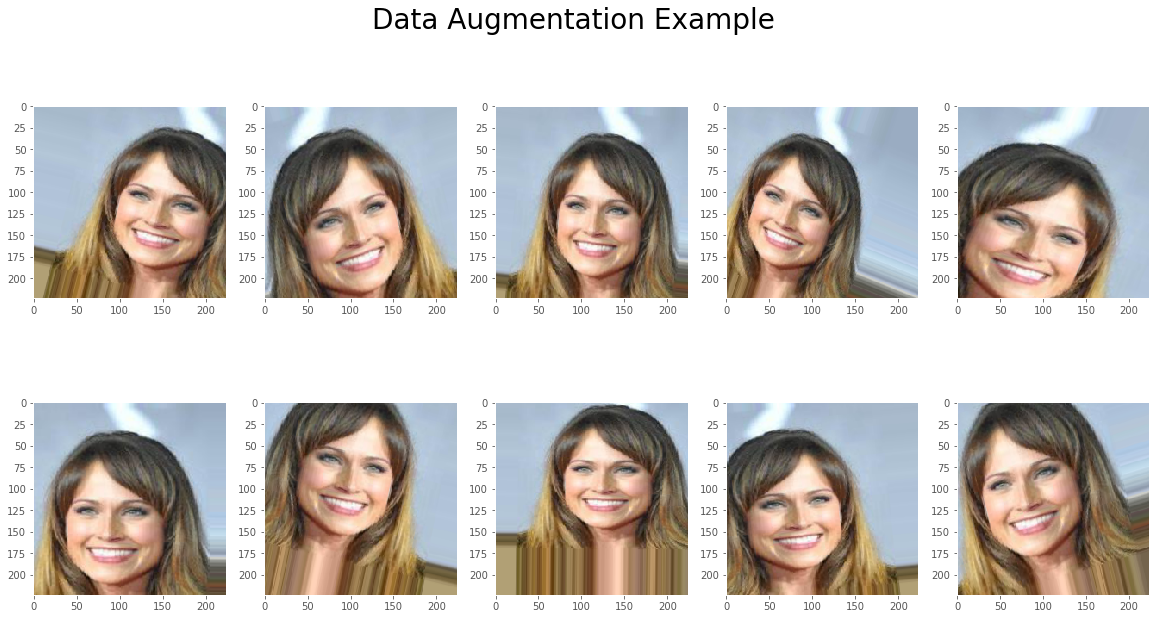

In [0]:
# ------------------------------------------------------------------------------
# -- Example of the augmented samples:
# ------------------------------------------------------------------------------

def load_reshape_img(path, shape=IMG_SHAPE):
  img = load_img(path, target_size=shape)
  x = img_to_array(img) / 255.0
  x = x.reshape((1, ) + x.shape)
  return x


# select and load a picture:
sample_path = os.path.join(celeba.images_folder, train_split.sample(1).index[0])
sample = load_reshape_img(sample_path)

# plot ten augmented images
plt.figure(figsize=(20, 10))
plt.suptitle('Data Augmentation Example', fontsize=28)

for i, image in enumerate(train_datagen.flow(sample, batch_size=1)):
  if i == 10:
    break
    
  plt.subplot(2, 5, i + 1)
  plt.grid(False)
  plt.imshow(image.reshape(IMG_SHAPE) * 255.)

_ = plt.show()

In [0]:
# ------------------------------------------------------------------------------
# -- Compile model
# ------------------------------------------------------------------------------

model.compile(loss='cosine_proximity',
              optimizer='adadelta',
              metrics=['binary_accuracy'])

In [0]:
# ------------------------------------------------------------------------------
# -- Checkpointing: at each epoch, the best model so far is saved
# ------------------------------------------------------------------------------

model_path = f"{save_path}/UL19/weights-FC37-MobileNetV2-2-" + "{val_binary_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(
    model_path,
    monitor='val_binary_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [0]:
# ------------------------------------------------------------------------------
# -- Fitting
# ------------------------------------------------------------------------------

history = model.fit_generator(
    train_generator,
    epochs=4,
    steps_per_epoch=len(train_generator),
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    max_queue_size=1,
    shuffle=True,
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/4
2544/2544 [==============================] - 1970s 774ms/step - loss: -0.8383 - binary_accuracy: 0.9094 - val_loss: -0.8243 - val_binary_accuracy: 0.9016

Epoch 00001: val_binary_accuracy improved from -inf to 0.90162, saving model to /content/gdrive/My Drive/modelli/keras/UL19/weights-FC37-MobileNetV2-2-0.90.hdf5
Epoch 2/4
2544/2544 [==============================] - 1979s 778ms/step - loss: -0.8419 - binary_accuracy: 0.9112 - val_loss: -0.8359 - val_binary_accuracy: 0.9108

Epoch 00002: val_binary_accuracy improved from 0.90162 to 0.91080, saving model to /content/gdrive/My Drive/modelli/keras/UL19/weights-FC37-MobileNetV2-2-0.91.hdf5
Epoch 3/4
2544/2544 [==============================] - 1966s 773ms/step - loss: -0.8447 - binary_accuracy: 0.9127 - val_loss: -0.8395 - val_binary_accuracy: 0.9122

Epoch 00003: val_binary_accuracy improved from 0.91080 to 0.91221, saving model to /content/gdrive/My Drive/modelli/keras/UL19/weights-FC37-MobileNetV2-2-0.91.hdf5
Epoch 4/4
2544/2

In [0]:
def plot_model_history(history):
  '''plots useful graphs about the model training: loss, accuracy, ecc.'''
  plt.plot(history.history['binary_accuracy'])
  plt.plot(history.history['val_binary_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  
# plot the training and validation loss for every epoch:
plot_model_history(history)

# 4. Testing
---
* Test Data Generator
* Evaluate performance on test-set
* Average Hamming Distance, Mis-predictions
* Plot Mis-predictions frequency, and accuracy per feature

In [0]:
# optionally load a pre-trained model:

model = keras.models.load_model(f"{save_path}/UL19/weights-FC37-MobileNetV2-0.92.hdf5")

In [0]:
# ------------------------------------------------------------------------------
# -- Data Generator for Test-Set
# ------------------------------------------------------------------------------

test_datagen = ImageDataGenerator(rescale=1./255)

test_set = celeba.split('test', drop_zero=False)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_set,
    directory=celeba.images_folder,
    x_col='image_id',
    y_col=celeba.features_name,
    target_size=TARGET_SIZE,
    batch_size=batch_size,
    class_mode='other'
)

Found 19962 validated image filenames.


In [0]:
# ------------------------------------------------------------------------------
# -- Evaluate Accuracy
# ------------------------------------------------------------------------------

score = model.evaluate_generator(
    test_generator,
    steps=len(test_generator),
    max_queue_size=1,
    verbose=1
)

print("Test score:", score[0])
print("Test accuracy:", score[1]) 

312/312 [==============================] - 42s 135ms/step
Test score: -0.8441728973493776
Test accuracy: 0.9095903822241297


In [0]:
def hamming_distance(x, y):
  '''Hamming distance: use to get the number of mis-predicted features'''
  assert(len(x) == len(y))
  
  count = 0
  for i in range(len(x)):
    if x[i] != y[i]:
      count += 1
  
  return count


def count_mistakes(preds, labels):
  '''For every feature counts the number mis-predictions'''
  mistakes = np.zeros(len(preds[0]))
  
  for i, pred in enumerate(preds):
    label = labels[i]
    
    for j in range(len(pred)):
      if pred[j] != label[j]:
        mistakes[j] += 1
    
  return mistakes


In [0]:
# ------------------------------------------------------------------------------
# -- Avg. Hamming Distance, Mis-predictedion frequency
# ------------------------------------------------------------------------------

mistakes = np.zeros(celeba.num_features)
count = 0
avg_d = 0
show_prob = 0.01

# generate samples (x), and labels (y) a batch at a time:
for i in range(len(test_generator)):
  x, y  = next(test_generator)
  preds = model.predict_on_batch(x)
  preds = np.round(preds).astype('int')  # make the prediction a binary vector
  count += len(x)
  
  mistakes += count_mistakes(preds, y)
  
  for i, p in enumerate(preds):
    d = hamming_distance(p, y[i])
    avg_d += d
    
    if random.random() <= show_prob:
      # prints: prediction, true labels, and their hamming distance
      print(f"pred: {p}") 
      print(f"true: {y[i]}")
      print(f"=> d = {d}")
    
# get average hamming distance:    
avg_d /= count
print("avg. hamming: " + str(avg_d))

mistakes = np.round(mistakes / count, 2)

pred: [1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1]
true: [0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1]
=> d = 6
pred: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1]
true: [0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 1]
=> d = 2
pred: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
true: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1]
=> d = 2
pred: [0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 1 0 0 1]
true: [0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0]
=> d = 6
pred: [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
true: [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
=> d = 1
pred: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 1]
true: [0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 

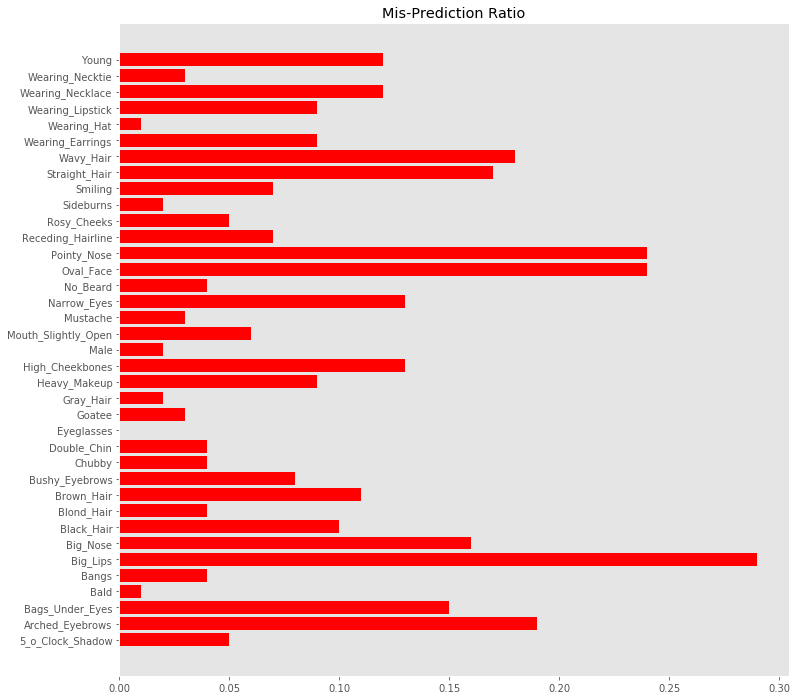

In [0]:
# plot mis-predicted feature ratio

plt.figure(figsize=(12, 12))

plt.barh(celeba.features_name, mistakes, color='red')
plt.title("Mis-Prediction Ratio")
plt.grid(False)

_ = plt.show()

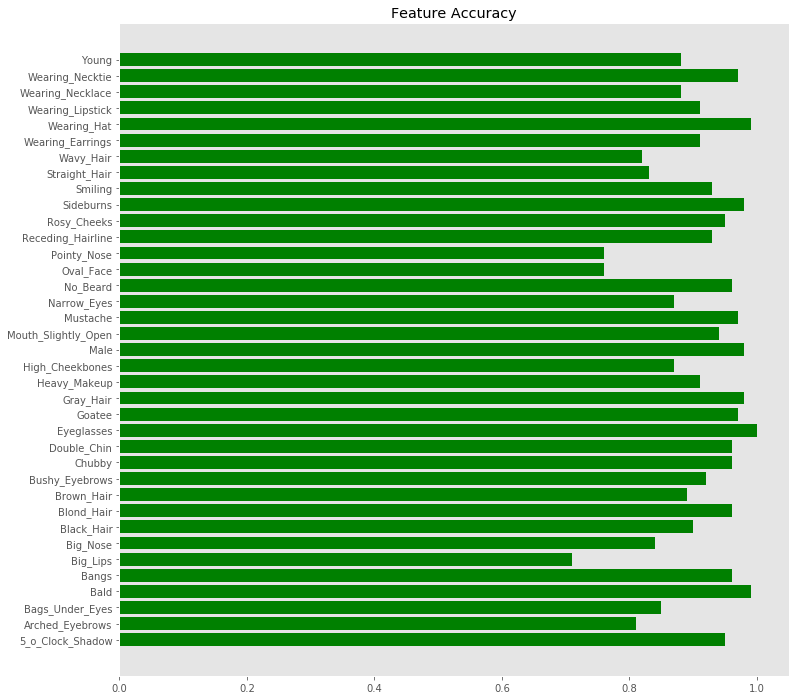

In [0]:
# plot feature accuracy
plt.figure(figsize=(12, 12))

plt.barh(celeba.features_name, 1 - mistakes, color='green')
plt.title("Feature Accuracy")
plt.grid(False)

_ = plt.show()